## LoRAs of the World Unite - Training SOTA DreamBooth LoRA with Pivotal Tuning 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) using some of the most popular SOTA methods.

Learn more about the techniques used in this exmaple [here](linke to blogpost)

Let's get started 🧪

## Setup 🪓

In [7]:
# Install dependencies.
!pip install xformers bitsandbytes transformers accelerate wandb dadaptation prodigyopt -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s 

In [8]:
!pip install peft -q

Make sure to install `diffusers` from `main`.

In [9]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Download diffusers SDXL DreamBooth training script.

In [10]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/advanced_diffusion_training/train_dreambooth_lora_sdxl_advanced.py

--2024-11-07 03:34:57--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/advanced_diffusion_training/train_dreambooth_lora_sdxl_advanced.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108005 (105K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl_advanced.py’

train_dreambooth_lo 100%[===================>] 105.47K  --.-KB/s    in 0.02s   

2024-11-07 03:34:57 (6.30 MB/s) - ‘train_dreambooth_lora_sdxl_advanced.py’ saved [108005/108005]



## Dataset 🐶

**Let's get our training data!**
For this example, we'll download some images from the hub.

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions,
pick option 1 or 2 below.

**Option 1:** upload example images from your local files:

In [11]:
import os
from google.colab import files

# pick a name for the image folder
local_dir = "./my_folder" #@param
os.makedirs(local_dir)
os.chdir(local_dir)

# choose and upload local images into the newly created directory
uploaded_images = files.upload()
os.chdir("/content") # back to parent directory

**Option 2:** download example images from the hub -

In [12]:
from huggingface_hub import snapshot_download

local_dir = "./3d_icon" #@param
dataset_to_download = "LinoyTsaban/3d_icon" #@param
snapshot_download(
    dataset_to_download,
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 25 files:   0%|          | 0/25 [00:00<?, ?it/s]

05.jpg:   0%|          | 0.00/2.80M [00:00<?, ?B/s]

01.jpg:   0%|          | 0.00/371k [00:00<?, ?B/s]

07.jpg:   0%|          | 0.00/170k [00:00<?, ?B/s]

06.jpg:   0%|          | 0.00/185k [00:00<?, ?B/s]

02.jpg:   0%|          | 0.00/541k [00:00<?, ?B/s]

04.jpg:   0%|          | 0.00/383k [00:00<?, ?B/s]

00.jpg:   0%|          | 0.00/312k [00:00<?, ?B/s]

03.jpg:   0%|          | 0.00/631k [00:00<?, ?B/s]

08.jpg:   0%|          | 0.00/3.40M [00:00<?, ?B/s]

09.jpg:   0%|          | 0.00/268k [00:00<?, ?B/s]

10.jpg:   0%|          | 0.00/2.16M [00:00<?, ?B/s]

12.jpg:   0%|          | 0.00/173k [00:00<?, ?B/s]

11.jpg:   0%|          | 0.00/435k [00:00<?, ?B/s]

13.jpg:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

14.jpg:   0%|          | 0.00/164k [00:00<?, ?B/s]

16.jpg:   0%|          | 0.00/296k [00:00<?, ?B/s]

15.jpg:   0%|          | 0.00/252k [00:00<?, ?B/s]

19.jpg:   0%|          | 0.00/481k [00:00<?, ?B/s]

20.jpg:   0%|          | 0.00/381k [00:00<?, ?B/s]

17.jpg:   0%|          | 0.00/204k [00:00<?, ?B/s]

21.jpg:   0%|          | 0.00/355k [00:00<?, ?B/s]

18.jpg:   0%|          | 0.00/186k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/462 [00:00<?, ?B/s]

22.jpg:   0%|          | 0.00/537k [00:00<?, ?B/s]

metadata.jsonl:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

'/content/3d_icon'

Preview the images:

In [13]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (132710400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


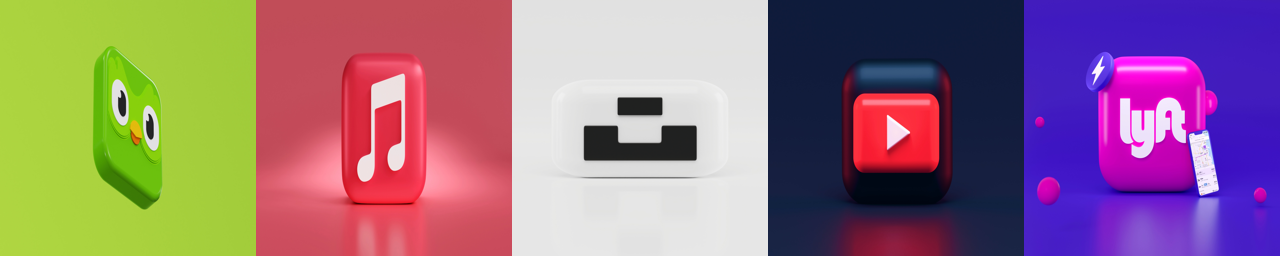

In [14]:
import glob
local_dir = "./3d_icon"
img_paths = f"{local_dir}/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Generate custom captions with BLIP

Load BLIP2 to auto caption your images:


**Note:** if you downloaded the `LinoyTsaban/3d_icon dataset` from the hub, you would find it already contains captions (generated with BLIP and prefixed with a token identifier) in the `metadata.jsonl` file
You can skip this part if you wish to train on that dataset using the existing captions.

In [15]:
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
# load pipelines
blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",torch_dtype=torch.float16).to(device)

## IMAGE CPATIONING ##
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./3d_icon/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (132710400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.

*Note:* When training with **pivotal tuning**, this token identifier (e.g. TOK) is only a **place holder**, and will be mapped to new tokens we insert to the tokenizers - so no need to spend too much time choosing the token!

Change the prefix according to the concept you're training on:
- for this example we can use "In the style of TOK," other options include:
    - For objects - "photoof a TOK/ a TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "In the style of TOK" we can use "3d icon in the style of TOK"/"a TOK 3d style icon"

saves image paths and corresponding prompts to metadata file for training

In [17]:
import json
from IPython.display import display, Markdown

caption_prefix = "3d icon in the style of TOK, " #@param

# saves each caption and corresponding image to a metadata.jsonl file
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

display(Markdown(f"Your image captions are ready here: {local_dir}metadata.jsonl"))

Your image captions are ready here: ./3d_icon/metadata.jsonl

Free some memory:

In [18]:
import gc

# delete the BLIP2 pipelines and clear up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training 💻

Initialize `accelerate`:

In [19]:
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [28]:
from huggingface_hub import notebook_login
notebook_login()

## Train! 🔬

### `Diffusers` 🧨 Training loop

### hyperparameters 📐
1. **How to choose your hyperparams?** Check out this [blog post]() - where we explore and comapre different hyperparmas and configurations for different use cases, depending on your data and subject.     

2. **Make sure to add** `push_to_hub` so that the checkpoint is automatically pushed to the Hub and doesn't get lost. The `--push_to_hub` argument ensures that the trained checkpoints are automatically pushed to the Hugging Face Hub.

3. Some paramters that can help us with **compute** when doing DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL:

    * Gradient checkpointing (`--gradient_accumulation_steps`)
    * 8-bit Adam (`--use_8bit_adam`) - optional when using `--optimizer='AdamW'`, with `--optimizer='Prodigy'` this will be ignored
    * Mixed-precision training (`--mixed-precision="bf16"`)



### Launch training 🚀🚀🚀

**To allow for custom captions** we need to install the `datasets` library:
- Use `--caption_column` to specify name of the cpation column in your dataset.
    - In this example we used `"prompt"` to
       save our captions in the metadata file, change this according to your needs.

**Otherwise:**
- you can skip the installation if you want to train soley with `--instance_prompt`.
  in that case, specify `--instance_data_dir` instead of `--dataset_name`

In [21]:
# makes sure we install datasets from main
!pip install git+https://github.com/huggingface/datasets.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torchaudio 2.5.0+cu121 requires torch==2.5.0, but you have torch 2.5.1 which is incompatible.
torchvision 0.20.0+cu121 requires torch==2.5.0, but you have torch 2.5.1 which is incompatible.


#### 🤗Pick a name for your Dreambooth LoRA fine-tuned model:🤗
This name will be used to save your model, so pick an informative name based on your chosen concept💡

In [22]:
!pip install python-slugify
from slugify import slugify

model_name = "3d icon SDXL LoRA" # @param
output_dir = slugify(model_name)

**Instance & Validation Prompt**
* `instance_prompt` -
    * when custom captions are enabled this prompt is still used in case there are missing captions, as well as in the model's readme.
    * If custom captions are not used, this prompt will be used as the caption for all training images.
* `validation_prompt` -
    * this prompt is used to generate images throught the training process, this way you can see the models learning curve during training.
    * you can also change `num_validation_images` (4 by default) and `validation_epochs` (50 by default) to control the amount images generated with the validation prompt, and the number of ephochs between each dreambooth validation.  

In [23]:
instance_prompt = "3d icon in the style of TOK" # @param
validation_prompt = "a TOK icon of an astronaut riding a horse, in the style of TOK" # @param

**Set your LoRA rank**
The rank of your LoRA is linked to its expressiveness.
The bigger the rank the closer we are to regular dreambooth, and in theory we have more expressive power (and heavier weights).

For a very simple concept that you have a good high quality image set for (e.g. a pet, a generic object), a rank as low as 4 can be enough to get great results. We reccomend going between 8 and 64 depending on your concept and how much of a priortiy it is for you to keep the LoRA small or not.  

In [24]:
rank = 8 # @param

In [25]:
!python3 test.py

Hello


In [30]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl_advanced.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="./3d_icon" \
  --instance_prompt="$instance_prompt" \
  --validation_prompt="$validation_prompt" \
  --output_dir="$output_dir" \
  --caption_column="prompt" \
  --mixed_precision="bf16" \
  --resolution=1024 \
  --train_batch_size=1 \
  --repeats=1 \
  --report_to="wandb"\
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --learning_rate=1.0 \
  --text_encoder_lr=1.0 \
  --adam_beta2=0.99 \
  --optimizer="prodigy"\
  --train_text_encoder_ti\
  --train_text_encoder_ti_frac=0.5\
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --rank="$rank" \
  --max_train_steps=1000 \
  --checkpointing_steps=2000 \
  --seed="0" \
  --push_to_hub

2024-11-07 04:01:33.542638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 04:01:33.773694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 04:01:33.832768: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 04:01:36.172419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/07/2024 04:01:39 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: bf16

You are using a model of type clip_text_model to instantiate a model of ty

### Check out your model 🔥

In [27]:
from huggingface_hub import whoami
from pathlib import Path
from IPython.display import display, Markdown

username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

link_to_model = f"https://huggingface.co/{repo_id}"

display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

HTTPError: Invalid user token. If you didn't pass a user token, make sure you are properly logged in by executing `huggingface-cli login`, and if you did pass a user token, double-check it's correct.

## Inference 🐕

In [ ]:
import torch
from huggingface_hub import hf_hub_download, upload_file
from diffusers import DiffusionPipeline
from diffusers.models import AutoencoderKL
from safetensors.torch import load_file

pipe = DiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        torch_dtype=torch.float16,
        variant="fp16",
).to("cuda")


pipe.load_lora_weights(repo_id, weight_name="pytorch_lora_weights.safetensors")


#### Load Pivotal Tuning Embeddings

In [ ]:
text_encoders = [pipe.text_encoder, pipe.text_encoder_2]
tokenizers = [pipe.tokenizer, pipe.tokenizer_2]

embedding_path = hf_hub_download(repo_id=repo_id, filename="embeddings.safetensors", repo_type="model")

state_dict = load_file(embedding_path)
# load embeddings of text_encoder 1 (CLIP ViT-L/14)
pipe.load_textual_inversion(state_dict["clip_l"], token=["<s0>", "<s1>"], text_encoder=pipe.text_encoder, tokenizer=pipe.tokenizer)
# load embeddings of text_encoder 2 (CLIP ViT-G/14)
pipe.load_textual_inversion(state_dict["clip_g"], token=["<s0>", "<s1>"], text_encoder=pipe.text_encoder_2, tokenizer=pipe.tokenizer_2)

In [ ]:
instance_token = "<s0><s1>"
prompt = f"a {instance_token} icon of an orange llama eating ramen, in the style of {instance_token}"

image = pipe(prompt=prompt, num_inference_steps=25, cross_attention_kwargs={"scale": 1.0}).images[0]
image




In [ ]:
#@title Radio App

import gradio as gr

def greet(name):
  return "Hello " + name + "!"

iface = gr.Interface(fn=greet, inputs="text", outputs="text")
iface.launch()